# 

# Evaluating the method
See the readme file for details

The promt message is a structured query that tells the model how to respond it follows the chatgpt api definition. There are different ways to do that, pls take a look at: https://platform.openai.com/docs/api-reference/debugging-requests

In [1]:
import copy
def format_message(prompt_message:list, Text:str):
    msg = copy.deepcopy(prompt_message)
    try:
        # Check if the template contains the required placeholders
        template = msg[2]['content']
        if "{Text}" not in template:
            raise ValueError("The template is missing required placeholders: 'Text'")
        
        # Format the template
        msg[2]['content'] = template.format(Text=Text)
        return msg
    except Exception as e:
        raise Exception(f"Failed to format the message: {e}")


Show how the message looks like

In [ ]:
display(format_message(prompt_message, "Where is Zürich?", "somewhere in Switzerland"))

## LLM interface description
the function `makeCompute` takes three paremeter prompt_message, model, local.

* `promt_message` list of dict. containing the message log for the llm
* `model` string. of the ollama model or openrouter model. Supported openrouter models are described here: https://openrouter.ai/models
* `local` boolean. True calles ollama (make sure that ollama runs) False takes openrouter (make sure that you have the api keys in keys.py)


In [3]:
from llm import *
import json
import re
#model = "llama3.1"
#model = "deepseek/deepseek-chat"
model = "openai/o1-preview"
local = False
#prompt_message = prompt_message

def extract_json(response):
    # Regex pattern to match a JSON object
    json_pattern = re.compile(r'\{.*\}', re.DOTALL)
    
    # Search for the JSON pattern in the response
    match = json_pattern.search(response)
    
    if match:
        try:
            # Extract the JSON string and parse it
            json_str = match.group(0)
            return json.loads(json_str)
        except json.JSONDecodeError as e:
            print(f"Extracted JSON is invalid: {json_str}")
            raise Exception(f"JSONDecodeError: {e}")
    else:
        raise Exception("No JSON found in the response.")

def dehum_single_test(msg, Text, explanation=False, model=model, local=local):
    """
    Helper function to test a single prompt template.
    If explanation=True, use the prompt template with explanation suffix.
    Returns a tuple (answer, explanation) if explanation=True, else just the answer.
    """
    if explanation:
        # Use the prompt template with explanation suffix
        prompt = msg["explanation"]
    else:
        # Use the standard prompt template
        prompt = msg["standard"]

    response = makeCompute(
        messages=format_message(prompt, Text), 
        model=model, 
        local=local)
    try:
        if explanation:
        # Parse the JSON response to extract the answer and explanation
            return  json.loads(response)
        else:
            # Return the direct response
            return {"answer":response}
    except json.JSONDecodeError as e:
        # Log the invalid response for debugging
        print(f"Invalid JSON response: {response}")
        
        try:
            # Remove extra data or fix formatting
            return extract_json(response)
        except Exception as e:
            raise Exception(f"Failed to parse JSON: {e}")
        
    except Exception as e:
        # TODO, here the model could be feed its answer to itself to auto correct -> this is know as agentic llm flows could also generally be implemented to boost performance
        raise Exception(f"Value error response: {response}is not what it should be err: {e}")
    

In [ ]:
# test result:
print(dehum_single_test(
    Question = "Does the headline mention all involved parties?",
    Article = "Dad watched in horror as sheep farmer son, 23, killed by Audi A3\n" ))

In [4]:
# This file contains the actuall text messages:
from testcases import *
prompts = improved_prompts

def dehumanisation_test(Title, Article, explanation=False, model=model, local=local):
    """
    Main function to test for dehumanisation.
    If explanation=True, returns a tuple (failure_code, explanation) if a test fails.
    If explanation=False, returns just the failure_code.
    """
    # Test 1: All parties mentioned
    result = dehum_single_test(prompts["prompt_all_parties"], Text=Title, explanation=explanation, model=model, local=local)
    if result["answer"] == 0:
        return (0, result["explanation"]) if explanation else 0
   
    # Test 2: All parties referred to as humans
    result = dehum_single_test(prompts["prompt_human_reference"], Text=Title,explanation=explanation, model=model, local=local)
    if result["answer"] == 0:
        return (1, result["explanation"]) if explanation else 1

    # Test 3: Grammatical subject is human
    result = dehum_single_test(prompts["prompt_subject"], Text=Title,explanation=explanation, model=model, local=local)
    if result["answer"] == 0:
        return (2, result["explanation"]) if explanation else 2

    # Test 4: Text is written in active grammar
    result = dehum_single_test(prompts["prompt_active_grammar"], Text=Title, explanation=explanation, model=model, local=local)
    if result["answer"] == 0:
        return (3, result["explanation"]) if explanation else 3

    # Test 5: Physical or psychological consequences mentioned
    result = dehum_single_test(prompts["prompt_consequences_mentioned"], Text=Title + "\n" + Article, explanation=explanation, model=model, local=local)
    if result["answer"] == 0:
        return (4, result["explanation"]) if explanation else 4

    # Test 6: Crash placed in a larger pattern
    result = dehum_single_test(prompts["prompt_larger_pattern"], Text=Title + "\n" + Article, explanation=explanation, model=model, local=local)
    if result["answer"] == 0:
        return (5, result["explanation"]) if explanation else 5

    # If no test fails
    return (6, "No dehumanisation detected.") if explanation else 6



In [18]:
print("Dehumanisation test result is: ",
    dehumanisation_test(
        Title="Two Drivers Injured in Downtown Collision; Third Crash at Intersection This Month",
        Article="Two drivers, John and Sarah, were injured in a collision at the busy downtown intersection yesterday. John suffered a broken arm, while Sarah was treated for shock. This incident marks the third crash at this intersection in the past month, raising concerns about traffic safety. Authorities have announced plans to install additional traffic lights to prevent future accidents.",  
        explanation=True
    )
)

All parties (the two drivers involved) are mentioned in the headline.
Dehumanisation test result is:  (3, 'The headline is in passive grammar (subject receives the action).')


Lets try with an example from road danger with a high score

In [ ]:
print("Dehumanisation test result is: ",
    dehumanisation_test(
        Title="Woman runs over toddler in Woerden and runs off",
        Article="Police are looking for a young woman who hit a toddler with her bicycle in Woerden last Monday. The woman drove on, while the little boy sustained a broken leg and head injury from the collision.\nThe woman with long blonde hair and dark clothing, estimated to be between 17 and 21 years old, was cycling on Adriaan Duyckpad from the direction of the railway station at around 4pm. She was presumably riding an electric bike at high speed when a 3-year-old boy suddenly crossed the road.\nAlthough the woman stopped for a moment after a bystander spoke to her, she did not announce herself and rode on again. The police would now like to get in touch with her.",  
         explanation=False
    )
)

All parties (the woman who ran over the toddler and the toddler) are mentioned.
Dehumanisation test result is:  (4, 'Consequences are mentioned for the toddler but not for all parties.')


In [27]:
print("Dehumanisation test result is: ",
    dehumanisation_test(
        Title="Highway Collision Causes Traffic Delays, Investigation Underway",
        Article="A vehicle collision occurred late last night on Highway 27, resulting in significant traffic delays. Emergency services were quick to respond, and the scene was cleared within two hours. Witnesses reported seeing a car swerve abruptly before the crash, but details about the driver or passengers remain unclear. Authorities are investigating the cause of the incident, which is the second reported accident on this stretch of road in the past week.",  
        explanation=True
    )
)

Dehumanisation test result is:  (0, 'No parties involved in the accident are mentioned.')


## Comparision with labled data (english translation)

In [5]:
from roaddanger_data import *
df = get_labled_data()

def get_random_sample(df, score, sample_size):
    filtered_df = df[df["dehumanisation_score"] == score]
    return filtered_df.sample(n=sample_size,random_state=42)

C:\Users\david\AppData\Roaming\Python\Python311\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [6]:


def get_element(article, score):
    headline = translate_text(article["headline"])
    text = translate_text(article["alltext"])
    result =dehumanisation_test(
        Title = headline,
        Article = text,
        explanation=True,
        model="openai/o1-preview"
    )
    
    return {
            "articleid": article["articleid"],
            "Headline_dutch":article["headline"],
            "Text_dutch": article["alltext"],
            "Headline": translate_text(article["headline"]),
            "Text": translate_text(article["alltext"]),
            "Expected_result": score,
            "llm_result": result
        }

In [11]:
test_comp =[]
sample_size = 10
test = 2
def comp_func():
    for i in range(7):
        print(f"running for dehumanisation score: {i}")
        data = get_random_sample(df, i, sample_size=sample_size)
        tasks = []
        for index, article in data.iterrows():
            task = get_element(article, i)
            tasks.append(task)
        
        # Await all tasks to complete
        
        test_comp.extend(tasks)
comp_func()


running for dehumanisation score: 0
Invalid JSON response: ```json
{"answer": 0, "explanation": "Only one party (deceased Johnathan) is mentioned."}
```
running for dehumanisation score: 1
Invalid JSON response: ```json
{"answer": 1, "explanation": "Both involved parties (cyclist and car) are mentioned."}
```
running for dehumanisation score: 2
running for dehumanisation score: 3
running for dehumanisation score: 4
running for dehumanisation score: 5


TypeError: 'NoneType' object is not subscriptable

In [12]:
display(test_comp)
# Save results to JSON
with open("test_comp2.json", "w", encoding="utf-8") as f:
    json.dump(test_comp, f, ensure_ascii=False, indent=4)
print("test_comp saved to test_comp.json")

[{'articleid': '14297',
  'Headline_dutch': 'Vrienden van overleden Johnathan (14) leggen bloemen bij kruispunt',
  'Text_dutch': 'Op het Mondriaan College in Oss werd dinsdag de 14-jarige Johnathan herdacht. Leerlingen konden met elkaar en met docenten praten en brieven schrijven, ook was slachtofferhulp aanwezig. De jongen kwam zondagnacht om het leven. De auto waar hij met zijn familie in zat, werd in Oss aangereden door een wagen die met hoge snelheid door rood reed. \n\n"Hij was mijn beste vriend. Ik ken hem bijna vier jaar, ik kreeg van school en van een vriend te horen dat de jongen die was omgekomen bij het ongeluk Johnathan was", zo vertelt Amir bij de geïmproviseerde herdenkingsplek waar bloemen liggen en kaarsjes zijn aangestoken. "Het is heel heftig, ik had het nadat ik het hoorde, echt even moeilijk. We hebben net bloemen neergelegd. Ook op school is hij herdacht."\n\nAmir is daar blij mee. "Het is fijn dat over hem wordt gepraat, ook op het nieuws. Daardoor wordt hij niet

test_comp saved to test_comp.json


In [ ]:
import matplotlib.pyplot as plt
data = test_comp
# Initialize a dictionary to store accuracy for each test
test_accuracy = {i: {'correct': 0, 'total': 0} for i in range(7)}

# Calculate accuracy for each test
for entry in data:
    expected = entry['Expected_result']
    predicted = entry['llm_result'][0]  # Extract the numeric part of llm_result
    test_accuracy[expected]['total'] += 1
    if predicted == expected:
        test_accuracy[expected]['correct'] += 1

# Calculate accuracy for each test
accuracy_results = {test: (info['correct'] / info['total'] if info['total'] > 0 else 0) for test, info in test_accuracy.items()}

# Print accuracy for each test
for test, accuracy in accuracy_results.items():
    print(f"Test {test}: Accuracy = {accuracy * 100:.2f}%")

# Visualize the results
plt.figure(figsize=(10, 6))
plt.bar(accuracy_results.keys(), accuracy_results.values(), color='skyblue')
plt.xlabel('Test Label')
plt.ylabel('Accuracy')
plt.title('Accuracy for Each Test (0 to 6)')
plt.xticks(range(7))
plt.ylim(0, 1.1)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

ModuleNotFoundError: No module named 'matplotlib.plt'

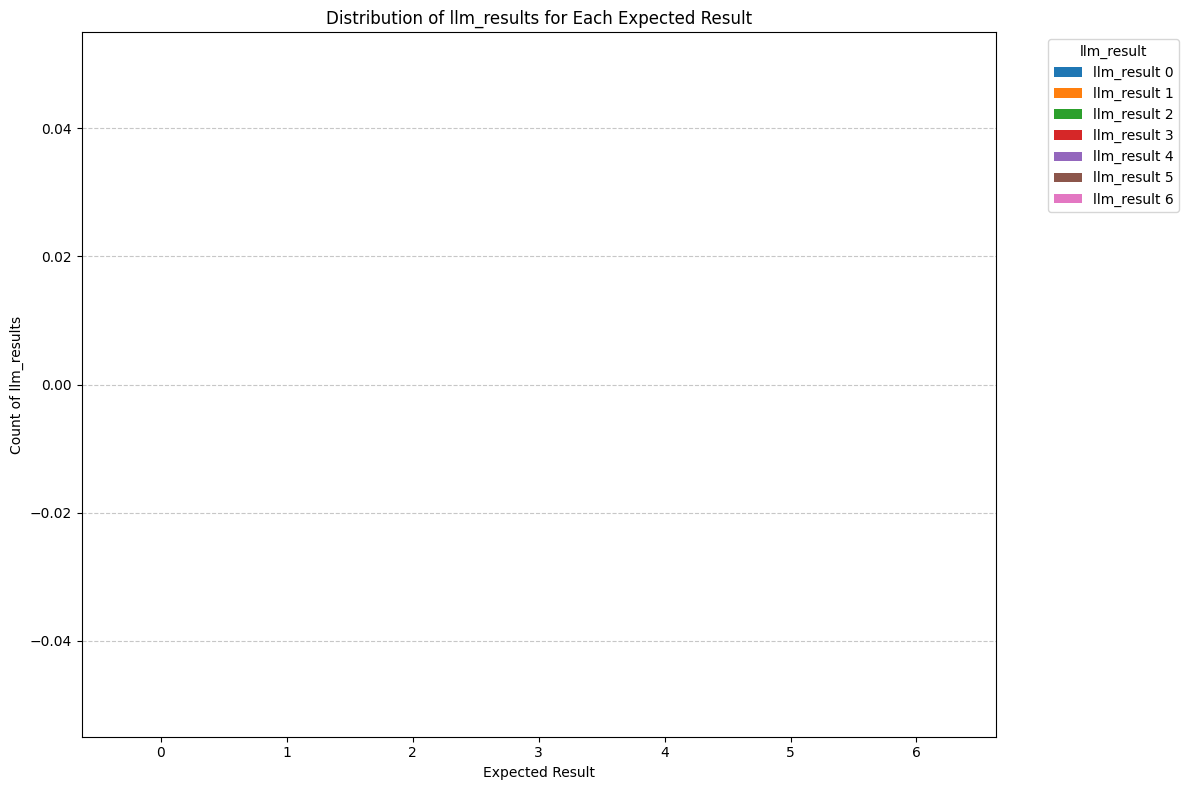

In [ ]:
from collections import defaultdict
# Initialize a dictionary to store the distribution
distribution = defaultdict(lambda: defaultdict(int))
data = [
    {'Expected_result': 4, 'llm_result': (4, 'Physical or psychological consequences are not mentioned for all parties.')},
    {'Expected_result': 2, 'llm_result': (2, 'Grammatical subject is not human.')},
    {'Expected_result': 4, 'llm_result': (3, 'Text is not written in active grammar.')},
    {'Expected_result': 1, 'llm_result': (1, 'All parties are referred to as humans.')},
    {'Expected_result': 5, 'llm_result': (5, 'Crash is placed in a larger pattern.')},
    {'Expected_result': 0, 'llm_result': (0, 'All parties are mentioned.')},
    # Add more data points here
]
# Populate the distribution dictionary
for entry in test_comp:
    expected = entry['Expected_result']
    predicted = entry['llm_result'][0]  # Extract the numeric part of llm_result
    distribution[expected][predicted] += 1

# Convert the distribution to a matrix
labels = range(7)  # Test labels 0 to 6
matrix = np.zeros((len(labels), len(labels)), dtype=int)

for expected in labels:
    for predicted in labels:
        matrix[expected][predicted] = distribution[expected][predicted]

# Plot the distribution as a stacked bar plot
plt.figure(figsize=(12, 8))
bar_width = 0.6
bottom = np.zeros(len(labels))

for predicted in labels:
    counts = matrix[:, predicted]
    plt.bar(labels, counts, bar_width, label=f'llm_result {predicted}', bottom=bottom)
    bottom += counts

plt.xlabel('Expected Result')
plt.ylabel('Count of llm_results')
plt.title('Distribution of llm_results for Each Expected Result')
plt.xticks(labels)
plt.legend(title='llm_result', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Stability test
lets run the test

In [1]:
small_models=[
 "qwen/qwq-32b-preview",
 "meta-llama/llama-3.2-3b-instruct",
 "mistralai/ministral-8b",
 "google/gemma-2-9b-it"
]
# Big models not used in the test
big_models= [
 "deepseek/deepseek-chat", # 
 "openai/o1-preview",
 "openai/gpt-4o-2024-11-20",
 "x-ai/grok-2-1212", 
 "meta-llama/llama-3.3-70b-instruct",
 "mistralai/mistral-large-2411"
]
s_result={}
SAMPLE_SIZE=15

for model in small_models:
    s_result[model] = []
    for i in range(SAMPLE_SIZE):
        try:  
            s_result[model].append(dehumanisation_test(
                Title="Woman runs over toddler in Woerden and runs off",
                Article="Police are looking for a young woman who hit a toddler with her bicycle in Woerden last Monday. The woman drove on, while the little boy sustained a broken leg and head injury from the collision.\nThe woman with long blonde hair and dark clothing, estimated to be between 17 and 21 years old, was cycling on Adriaan Duyckpad from the direction of the railway station at around 4pm. She was presumably riding an electric bike at high speed when a 3-year-old boy suddenly crossed the road.\nAlthough the woman stopped for a moment after a bystander spoke to her, she did not announce herself and rode on again. The police would now like to get in touch with her.",  
                explanation=False,
                model=model
            ))
        except Exception as e:
            print(f"model: {model} i: {i}, error: {e}")



model: qwen/qwq-32b-preview i: 0, error: name 'dehumanisation_test' is not defined
model: qwen/qwq-32b-preview i: 1, error: name 'dehumanisation_test' is not defined
model: qwen/qwq-32b-preview i: 2, error: name 'dehumanisation_test' is not defined
model: qwen/qwq-32b-preview i: 3, error: name 'dehumanisation_test' is not defined
model: qwen/qwq-32b-preview i: 4, error: name 'dehumanisation_test' is not defined
model: qwen/qwq-32b-preview i: 5, error: name 'dehumanisation_test' is not defined
model: qwen/qwq-32b-preview i: 6, error: name 'dehumanisation_test' is not defined
model: qwen/qwq-32b-preview i: 7, error: name 'dehumanisation_test' is not defined
model: qwen/qwq-32b-preview i: 8, error: name 'dehumanisation_test' is not defined
model: qwen/qwq-32b-preview i: 9, error: name 'dehumanisation_test' is not defined
model: qwen/qwq-32b-preview i: 10, error: name 'dehumanisation_test' is not defined
model: qwen/qwq-32b-preview i: 11, error: name 'dehumanisation_test' is not defined
mo

In [36]:
display(s_result)

{'qwen/qwq-32b-preview': [6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6],
 'meta-llama/llama-3.2-3b-instruct': [6,
  6,
  6,
  6,
  6,
  6,
  6,
  6,
  6,
  6,
  6,
  6,
  6,
  6,
  6],
 'mistralai/ministral-8b': [6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6],
 'google/gemma-2-9b-it': [6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6]}

The text used is an article from roaddanger, that i translated into english. The models selected for the test have a low parameter size. Bigger models are going to be more accurate since they are better to understand context. This result showcase that the test produces stable results also with entry models. 

# Cross language 

In [54]:
languages = ["English", "German", "Dutch", "Russian", "Romanian", "French"]


proficiency_criteria = """
1. **Grammar and Syntax**: 
   - Native: Perfect understanding and application of grammar rules.
   - Advanced: Strong grasp of grammar with rare errors.
   - Intermediate: Good understanding of basic grammar.
   - Basic: Frequent grammatical errors.
   - Limited: Minimal understanding of grammar.

2. **Vocabulary and Terminology**: 
   - Native: Extensive vocabulary, including idioms and slang.
   - Advanced: Broad vocabulary with occasional gaps.
   - Intermediate: Adequate vocabulary for everyday communication.
   - Basic: Limited vocabulary.
   - Limited: Very restricted vocabulary.

3. **Fluency and Coherence**: 
   - Native: Natural, fluent, and coherent text.
   - Advanced: Highly fluent with minor inconsistencies.
   - Intermediate: Generally coherent but may have awkward phrasing.
   - Basic: Struggles to maintain coherence.
   - Limited: Disjointed or nonsensical text.

4. **Cultural and Contextual Understanding**: 
   - Native: Fully understands cultural nuances and context.
   - Advanced: Strong cultural understanding but may miss subtle nuances.
   - Intermediate: Basic cultural awareness.
   - Basic: Limited cultural understanding.
   - Limited: No meaningful cultural understanding.

5. **Task-Specific Capabilities**: 
   - Native: Excels in all linguistic tasks.
   - Advanced: Performs well in most tasks.
   - Intermediate: Handles basic tasks.
   - Basic: Can perform very simple tasks.
   - Limited: Unable to perform meaningful tasks.
"""
# Proficiency scale description
proficiency_scale = """
- "Native" (fluent like a native speaker), 
- "Advanced" (excellent understanding and response capability), 
- "Intermediate" (good understanding but limited response capability), 
- "Basic" (can understand and respond to simple phrases), 
- "Limited" (minimal understanding or response capability).
"""
output_v1= """{{
  "language_proficiency": {{
    "Language1": {{
      "Grammar and Syntax": "ProficiencyLevel",
      "Vocabulary and Terminology": "ProficiencyLevel",
      "Fluency and Coherence": "ProficiencyLevel",
      "Cultural and Contextual Understanding": "ProficiencyLevel",
      "Task-Specific Capabilities": "ProficiencyLevel"
    }},
    "Language2": {{
      "Grammar and Syntax": "ProficiencyLevel",
      "Vocabulary and Terminology": "ProficiencyLevel",
      "Fluency and Coherence": "ProficiencyLevel",
      "Cultural and Contextual Understanding": "ProficiencyLevel",
      "Task-Specific Capabilities": "ProficiencyLevel"
    }},
    ...
  }}
}}"""
output_v2="""{{
  "language_proficiency": {{
    "Language1": "ProficiencyLevel",
    "Language2": "ProficiencyLevel",
    ...
  }}
}}"""

language_promt = f"""
You are an advanced language model. Evaluate your proficiency in the following languages and respond in JSON format. 
Use the following scale for proficiency: 
{proficiency_scale}

Languages to evaluate: {", ".join(languages)}

Respond in the following JSON format:
{output_v2}
"""

In [67]:
import asyncio

small_models=[
 "meta-llama/llama-3.2-3b-instruct",
 "meta-llama/llama-3.2-1b-instruct",
 "mistralai/ministral-8b",
 "google/gemma-2-9b-it",
 "cohere/command-r7b-12-2024"
]
medium_models = [
 "qwen/qwq-32b-preview",
 "meta-llama/llama-3.3-70b-instruct",
 "meta-llama/llama-3.3-70b-instruct",
 "google/gemma-2-27b-it",
 "anthropic/claude-3.5-haiku-20241022",
 "anthropic/claude-3.5-sonnet",
 "openai/o1-mini"
]
# Big models not used in the test
big_models= [
 "deepseek/deepseek-chat", # 
 "openai/o1-preview",
 "openai/o1",
 "openai/gpt-4o-2024-11-20",
 "x-ai/grok-2-1212", 
 "anthropic/claude-3-opus",
 "mistralai/mistral-large-2411"
]
lang_results = {}

# Async function to query a model
async def query_model(model, language_prompt):
    try:
        result =  await asyncio.to_thread(
            makeCompute,
            messages=[{"role": "user", "content": language_prompt}],
            model=model,
            local=False
        )
        lang_results[model] = result
    except Exception as e:
        print(f"model: {model} error: {e}")

In [68]:
import json
async def main(language_prompt, models):
    tasks = []
    for model in models:
        task = asyncio.create_task(query_model(model, language_prompt))
        tasks.append(task)
    
    # Await all tasks to complete
    await asyncio.gather(*tasks)

    # Save results to JSON
    with open("lang_results.json", "w", encoding="utf-8") as f:
        json.dump(lang_results, f, ensure_ascii=False, indent=4)
    print("lang_results saved to lang_results.json")

#small_models + medium_models + big_models
await main(language_prompt=language_promt, models=small_models + medium_models + big_models)

model: openai/o1 error: Error code: 403 - {'error': {'message': 'OpenAI is temporarily requiring a Tier 5 API key to access this model, which you can add [here](https://openrouter.ai/settings/integrations). You can also switch to o1-preview.', 'code': 403}}
lang_results saved to lang_results.json


In [49]:
display(lang_results)
import json

# Save lang_results to a JSON file
with open("lang_results.json", "w", encoding="utf-8") as f:
    json.dump(lang_results, f, ensure_ascii=False, indent=4)

print("lang_results saved to lang_results.json")

{'meta-llama/llama-3.2-3b-instruct': '```json\n{\n  "language_proficiency": {\n    "English": {\n      "Grammar and Syntax": "Advanced",\n      "Vocabulary and Terminology": "Native",\n      "Fluency and Coherence": "Native",\n      "Cultural and Contextual Understanding": "Advanced",\n      "Task-Specific Capabilities": "Native"\n    },\n    "German": {\n      "Grammar and Syntax": "Advanced",\n      "Vocabulary and Terminology": "Advanced",\n      "Fluency and Coherence": "Intermediate",\n      "Cultural and Contextual Understanding": "Intermediate",\n      "Task-Specific Capabilities": "Advanced"\n    },\n    "Dutch": {\n      "Grammar and Syntax": "Intermediate",\n      "Vocabulary and Terminology": "Basic",\n      "Fluency and Coherence": "Basic",\n      "Cultural and Contextual Understanding": "Basic",\n      "Task-Specific Capabilities": "Intermediate"\n    },\n    "Russian": {\n      "Grammar and Syntax": "Basic",\n      "Vocabulary and Terminology": "Basic",\n      "Fluency an

lang_results saved to lang_results.json


Error parsing JSON for model meta-llama/llama-3.2-1b-instruct: Extra data: line 13 column 1 (char 196)
Error parsing JSON for model anthropic/claude-3.5-sonnet: Extra data: line 12 column 1 (char 196)
Error parsing JSON for model anthropic/claude-3-opus: Expecting value: line 1 column 1 (char 0)
Error parsing JSON for model qwen/qwq-32b-preview: Expecting value: line 1 column 1 (char 0)


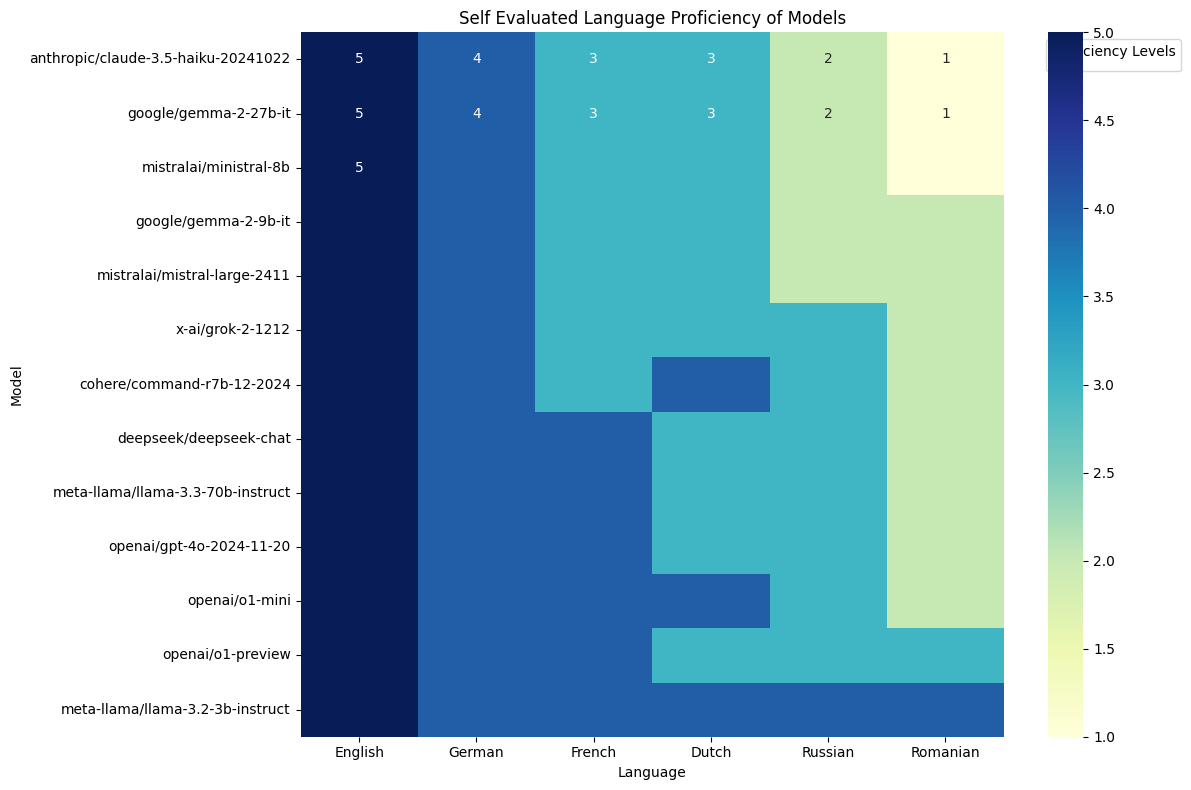

In [75]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Convert proficiency levels to numerical scores
proficiency_scores = {
    "Native": 5,
    "Advanced": 4,
    "Intermediate": 3,
    "Basic": 2,
    "Limited": 1
}

# Load the JSON data
with open("lang_results.json", "r", encoding="utf-8") as file:
    data = json.load(file)

# Parse the data and create a DataFrame
rows = []
for model, json_str in data.items():
    # Clean the JSON string (remove Markdown code blocks and extra braces)
    json_str = json_str.replace("```json", "").replace("```", "").strip()
    json_str = json_str.replace("{{", "{").replace("}}", "}")
    try:
        proficiency = json.loads(json_str)["language_proficiency"]
        for language, level in proficiency.items():
            rows.append({
                "Model": model,
                "Language": language,
                "Proficiency": proficiency_scores.get(level, 0)
            })
    except json.JSONDecodeError as e:
        print(f"Error parsing JSON for model {model}: {e}")

df = pd.DataFrame(rows)

# Define language order
language_order = ["English", "German", "French", "Dutch", "Russian", "Romanian"]

# Pivot the DataFrame for plotting
pivot_df = df.pivot(index="Model", columns="Language", values="Proficiency")
pivot_df = pivot_df[language_order]  # Reorder columns

# Calculate the average proficiency score for each model
average_scores = pivot_df.mean(axis=1)  # Calculate row-wise averages
ranked_models = average_scores.sort_values()  # Sort from worst to best

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(pivot_df.loc[ranked_models.index], annot=True, cmap="YlGnBu", fmt="d", vmin=1, vmax=5)
plt.title("Self Evaluated Language Proficiency of Models")
plt.xlabel("Language")
plt.ylabel("Model")

# Add a legend
legend_labels = [
    "5: Native",
    "4: Advanced",
    "3: Intermediate",
    "2: Basic",
    "1: Limited"
]
plt.legend(legend_labels, title="Proficiency Levels", bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

In this test models were promted to self evaluate their language skills in the respective language. Acuracy obviously might be an issue but its an indicator, after all its about the quantity of data in the respective langage that the model is trained on and the table above is indicating that models do are aware to a certain extend that the training data was not suffciant for that topic.

In [76]:
lang_dehumanisation_test = {
"English":{
    "Title":"Woman runs over toddler in Woerden and runs off",
    "Article":"Police are looking for a young woman who hit a toddler with her bicycle in Woerden last Monday. The woman drove on, while the little boy sustained a broken leg and head injury from the collision.\nThe woman with long blonde hair and dark clothing, estimated to be between 17 and 21 years old, was cycling on Adriaan Duyckpad from the direction of the railway station at around 4pm. She was presumably riding an electric bike at high speed when a 3-year-old boy suddenly crossed the road.\nAlthough the woman stopped for a moment after a bystander spoke to her, she did not announce herself and rode on again. The police would now like to get in touch with her."
    },
 "Dutch":{
    "Title": "Vrouw rijdt peuter aan in Woerden en gaat ervandoor",
    "Article": "De politie is op zoek naar een jonge vrouw die afgelopen maandag in Woerden met haar fiets een peuter aanreed. De vrouw reed door, terwijl het jongetje een beenbreuk en hoofdwond overhield aan de aanrijding."
 },
 "Russian":{
    "Title": "Женщина сбила малыша в Вордене и скрылась",
    "Article": "Полиция разыскивает молодую женщину, которая сбила малыша на велосипеде в Вордене в прошлый понедельник. Женщина поехала дальше, а маленький мальчик получил перелом ноги и травму головы.\nДвухлетняя женщина с длинными светлыми волосами и в темной одежде, на вид ей от 17 до 21 года, ехала на велосипеде по Adriaan Duyckpad со стороны железнодорожной станции примерно в 16:00. Предположительно, она ехала на электровелосипеде на высокой скорости, когда дорогу внезапно перебежал трехлетний мальчик.\nПосле того как прохожие обратились к ней, женщина остановилась, но не объявила о себе и поехала дальше. Полиция хотела бы связаться с ней."
 },
 "Rumanian":{
    "Title":"Femeia a călcat un copil mic în Woerden și a fugit",
    "Article":"Poliția caută o tânără care a lovit un copil mic cu bicicleta în Woerden lunea trecută. Femeia și-a continuat drumul, în timp ce băiețelul a suferit o fractură la picior și un traumatism cranian în urma coliziunii.\nFemeia cu păr lung și blond și îmbrăcăminte închisă la culoare, estimată a avea între 17 și 21 de ani, mergea cu bicicleta pe Adriaan Duyckpad din direcția gării în jurul orei 16.00. Se presupune că aceasta conducea o bicicletă electrică cu viteză mare atunci când un băiețel de 3 ani a traversat brusc strada.\nDeși femeia s-a oprit pentru o clipă după ce un trecător i-a vorbit, aceasta nu s-a anunțat și și-a continuat drumul. Poliția ar dori acum să ia legătura cu ea.",
 },
 "German":{
    "Title": "Frau überfährt Kleinkind in Woerden und flüchtet",
    "Article": "Die Polizei sucht eine junge Frau, die am vergangenen Montag in Woerden ein Kleinkind mit ihrem Fahrrad angefahren hat. Die Frau fuhr weiter, während der kleine Junge bei dem Zusammenstoß ein gebrochenes Bein und eine Kopfverletzung erlitt.\nDie Frau mit langen blonden Haaren und dunkler Kleidung, schätzungsweise zwischen 17 und 21 Jahre alt, war gegen 16 Uhr mit dem Fahrrad auf dem Adriaan Duyckpad aus Richtung Bahnhof unterwegs. Sie fuhr vermutlich mit einem Elektrofahrrad mit hoher Geschwindigkeit, als plötzlich ein 3-jähriger Junge die Straße überquerte.\nDie Frau hielt zwar kurz an, nachdem ein Passant sie angesprochen hatte, meldete sich aber nicht und fuhr weiter. Die Polizei bittet nun um Kontaktaufnahme mit ihr."
 },
 "French":{
    "Title" : "Une femme renverse un enfant en bas âge à Woerden et s'enfuit",
    "Article" : "La police est à la recherche d'une jeune femme qui a renversé un enfant en bas âge avec son vélo à Woerden lundi dernier. La femme a poursuivi sa route, tandis que le petit garçon a subi une fracture de la jambe et un traumatisme crânien à la suite de la collision.\nLa femme aux longs cheveux blonds et aux vêtements sombres, dont l'âge est estimé entre 17 et 21 ans, circulait à vélo sur Adriaan Duyckpad en direction de la gare aux alentours de 16 heures. Elle roulait vraisemblablement à grande vitesse sur un vélo électrique lorsqu'un enfant de 3 ans a soudainement traversé la route. Bien que la femme se soit arrêtée un instant après qu'un passant lui ait parlé, elle ne s'est pas annoncée et a repris sa route. La police aimerait maintenant entrer en contact avec elle",
 },
}
    

In [86]:
lang_test = {}

for language, text in lang_dehumanisation_test.items():
    lang_test[language] = dehumanisation_test(
                Title=text["Title"],
                Article=text["Article"],
                explanation=True,
                model="meta-llama/llama-3.2-3b-instruct")

In [87]:
display(lang_test)

{'English': (0, 'Only one party (woman) is mentioned.'),
 'Dutch': (0, 'Only one party (the woman driver) is mentioned.'),
 'Russian': (0,
  'Only one party (the woman) is mentioned, the infant is not specifically named or mentioned as having been injured.'),
 'Rumanian': (0,
  "Only one party (femeia, meaning 'woman') is mentioned, but the victim (a copil mic, meaning 'young child') is not specified as a party involved in the accident, only as the victim of the accident."),
 'German': (0,
  'Only one party (Frau) is mentioned, the other party (Kleinkind) is mentioned as being involved in the accident but only as a victim.'),
 'French': (0,
  'Only one party (une femme) is mentioned, but the victim (un enfant en bas âge) is not specifically named or described as being injured, only that she was thrown by the woman.')}

The model produces the same results in cross language performance but it makes the same mistake in every language.
This illustrates, that the models linguistigs performance is actually excellent but not so much the rest.

In [90]:
for language, text in lang_dehumanisation_test.items():
    lang_test[language] = dehumanisation_test(
                Title=text["Title"],
                Article=text["Article"],
                explanation=True,
                model="openai/o1-preview")

Invalid JSON response: ```json
{"answer": 0, "explanation": "No physical or psychological consequences are mentioned for all involved parties."}
```


In [89]:
display(lang_test)

{'English': (0,
  'Not all parties are mentioned. The vehicle used by the woman to run over the toddler is not specified.'),
 'Dutch': (4,
  'Consequences are only mentioned for the toddler, not for all parties.'),
 'Russian': (4,
  'Consequences are mentioned for the boy but not for all involved parties.'),
 'Rumanian': (4,
  'Physical consequences are mentioned for the boy, but not for all involved parties.'),
 'German': (4,
  'Consequences are only mentioned for the child, not for all involved parties.'),
 'French': (4,
  'Consequences are mentioned for the child but not for all parties.')}

In [93]:
for language, text in lang_dehumanisation_test.items():
    lang_test[language] = dehumanisation_test(
                Title=text["Title"],
                Article=text["Article"],
                explanation=True,
                model="cohere/command-r7b-12-2024")

In [94]:
display(lang_test)

{'English': (0,
  'Only one party (the woman) is mentioned in the incident, despite the mention of an accident involving a toddler.'),
 'Dutch': (0,
  'The headline only mentions a woman and a child. It is ambiguous if a pedestrian is involved in the accident as well, but the information is not sufficient to confirm this.'),
 'Russian': (0,
  'Only one party (the driver) is mentioned. The headline does not mention the child who was hit.'),
 'Rumanian': (0,
  "Though 'a copil mic' (a little child) is mentioned, it is not clear if other parties, such as a second driver or a pedestrian, were involved in the accident."),
 'German': (3,
  "The headline is in passive grammar (subject receives the action). The passive voice is indicated by the use of the preposition 'und' followed by the reflexive pronoun 'flüchtet', suggesting that the subject (the woman) is receiving the action (being driven over and fleeing)."),
 'French': (3,
  "The headline is in passive grammar. The subject ('une femme'

C:\Users\david\AppData\Roaming\Python\Python311\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
